**Task 1: Image preprocessing**

Image Size (Width x Height): 1128 x 549 pixels
Bit Depth: uint16
Number of Color Channels: 1


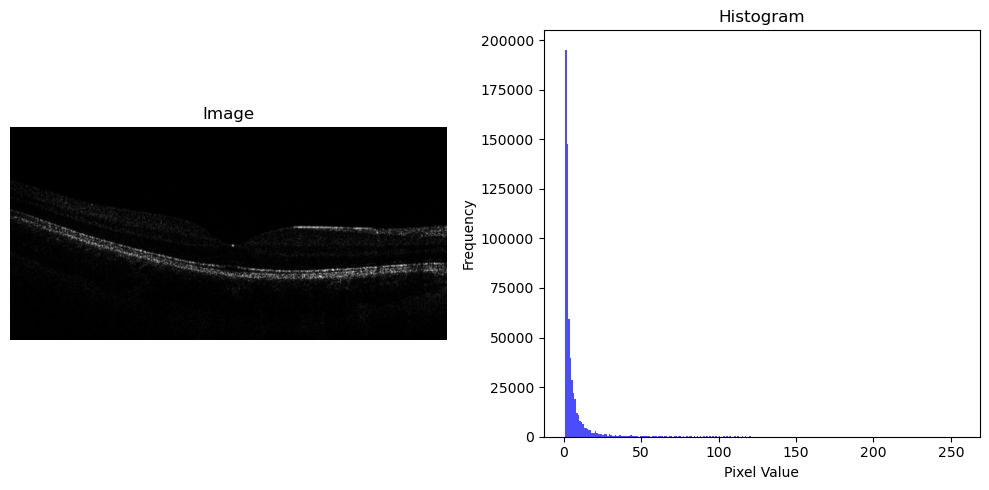

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the OCT image
image = cv2.imread("OCTimage_raw.tif", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)


# Check if the image was loaded successfully
if image is None:
    print("Image not loaded. Make sure the file exists and the path is correct.")
else:
    # Create a 1x2 subplot with the image and histogram side by side
    plt.figure(figsize=(10, 5))  # Define the figure size
    plt.subplot(1, 2, 1)  # Subplot for the image
    plt.imshow(image, cmap='Greys_r')
    plt.axis('off')  # Turn off the axis labels
    plt.title('Image')

    plt.subplot(1, 2, 2)  # Subplot for the histogram
    plt.hist(image.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')

# Get image size (width and height) and number of channels
try:
    height, width, channels = image.shape
except:
    height, width = image.shape
    channels = 1 #only grayscale

# Get bit depth
bit_depth = image.dtype

# Display the characteristics
print(f"Image Size (Width x Height): {width} x {height} pixels")
print(f"Bit Depth: {bit_depth}")
print(f"Number of Color Channels: {channels}") 


plt.tight_layout()  # Ensure the subplots don't overlap
plt.show()

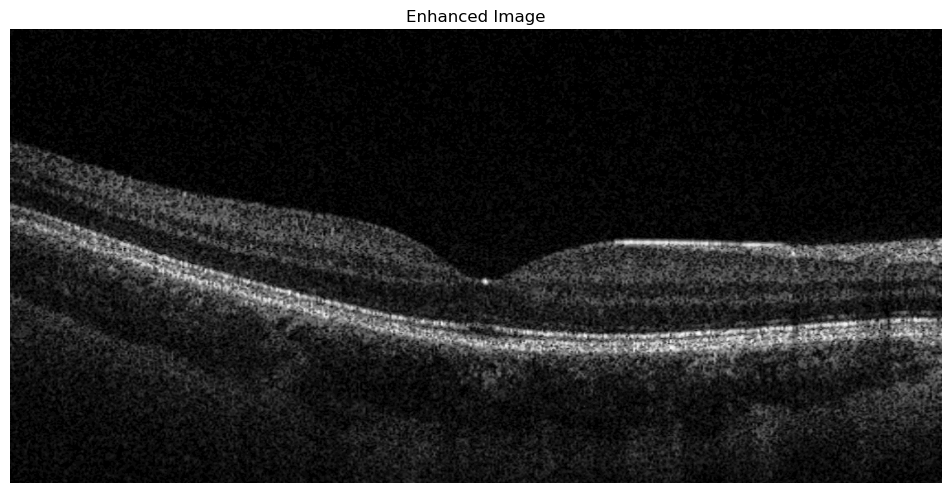

In [2]:
#Gamma correction 
gamma = .4  # Adjust the gamma value as needed
enhanced_image = np.power(image / 255.0, gamma)

plt.figure(figsize=(10, 5))  # Define the figure size
plt.imshow(enhanced_image, cmap='Greys_r')
plt.axis('off')  # Turn off the axis labels
plt.title('Enhanced Image')

plt.tight_layout()  # Ensure the subplots don't overlap
plt.show()

Text(0.5, 1.0, 'Denoised, normalized + gamma corrected')

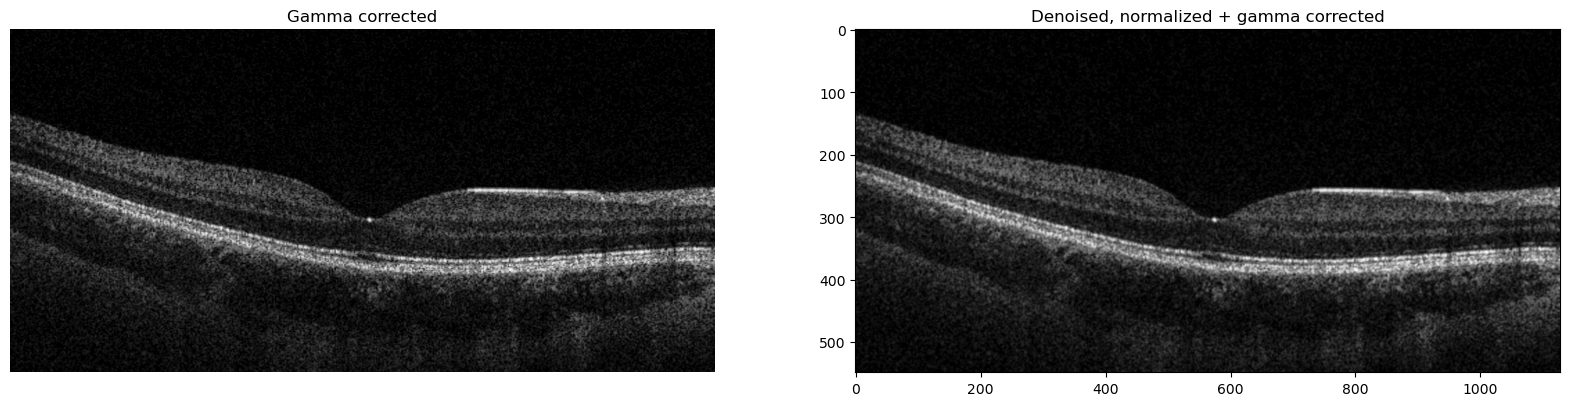

In [3]:
# Apply Gaussian filter to denoise the image
denoised_image = cv2.GaussianBlur(enhanced_image, (3, 3), 0)
# Normalize the image to the range [0, 1]
normalized_image = (denoised_image - np.min(denoised_image)) / (np.max(denoised_image) - np.min(denoised_image))

# Display the original and denoised images side by side
plt.figure(figsize=(20, 10))  # Define the figure size
plt.subplot(1, 2, 1)  # Subplot for the image
plt.imshow(enhanced_image, cmap='Greys_r')
plt.axis('off')  # Turn off the axis labels
plt.title('Gamma corrected')

plt.subplot(1, 2, 2)  # Subplot for the histogram
plt.imshow(normalized_image, cmap='Greys_r')
plt.title('Denoised, normalized + gamma corrected')

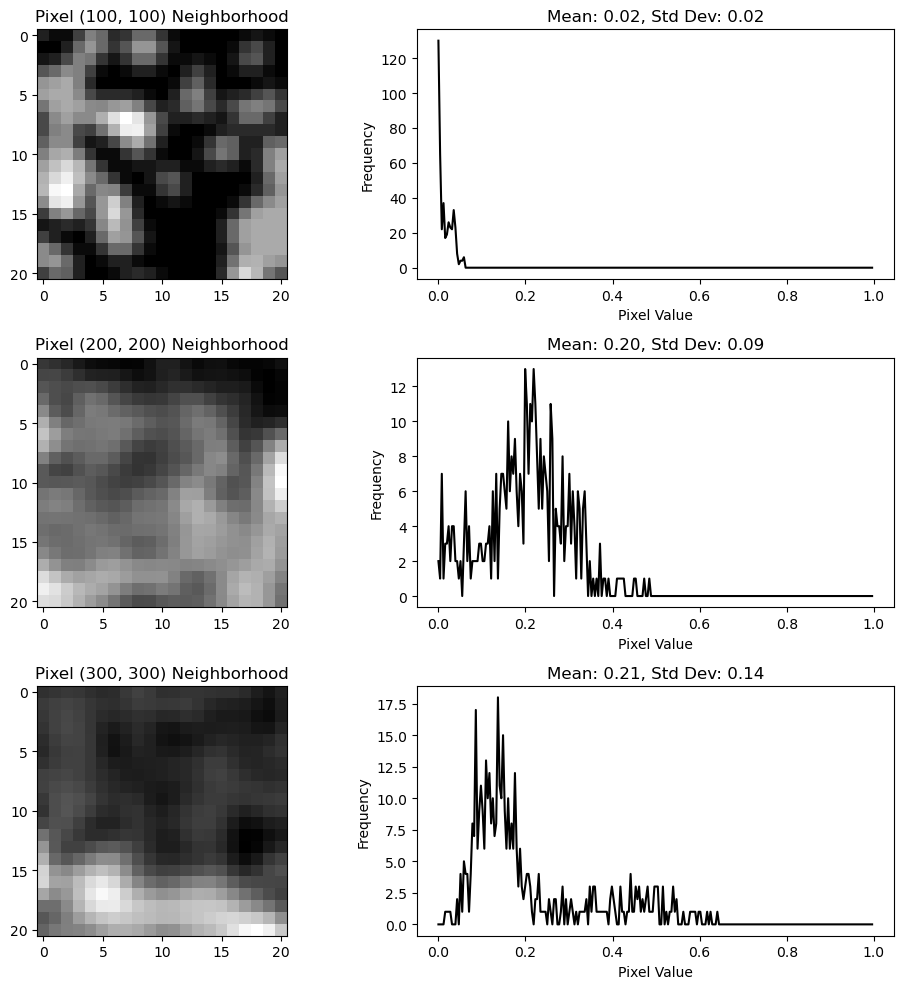

In [4]:
# Define the coordinates of the three pixels (x, y)
pixel_coordinates = [(100, 100), (200, 200), (300, 300)]

# Initialize the size of the neighborhood (21x21)
neighborhood_size = 21

# Create a single figure with multiple subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Analyze each of the three selected pixels
for i, (x, y) in enumerate(pixel_coordinates):
    # Check if the coordinates are within the image boundaries
    if x >= neighborhood_size // 2 and x < normalized_image.shape[1] - neighborhood_size // 2 and \
       y >= neighborhood_size // 2 and y < normalized_image.shape[0] - neighborhood_size // 2:

        # Extract the 21x21 neighborhood around the pixel
        neighborhood = normalized_image[y - neighborhood_size // 2: y + neighborhood_size // 2 + 1,
                            x - neighborhood_size // 2: x + neighborhood_size // 2 + 1]

        # Calculate mean and standard deviation of the neighborhood
        mean_value = np.mean(neighborhood)
        std_dev_value = np.std(neighborhood)

        # Calculate the histogram of the neighborhood
        hist, bins = np.histogram(neighborhood, bins=256, range=(0, 1))

        # Display the neighborhood image
        axs[i, 0].imshow(neighborhood, cmap='gray')
        axs[i, 0].set_title(f'Pixel {pixel_coordinates[i]} Neighborhood')

        # Plot the histogram
        axs[i, 1].plot(bins[:-1], hist, color='black')
        axs[i, 1].set_xlabel('Pixel Value')
        axs[i, 1].set_ylabel('Frequency')
        axs[i, 1].set_title(f'Mean: {mean_value:.2f}, Std Dev: {std_dev_value:.2f}')
    else:
        axs[i, 0].set_title(f'Pixel {pixel_coordinates[i]} is out of bounds')
        axs[i, 1].set_title('Histogram not available')

plt.tight_layout()
plt.show()

<Figure size 500x500 with 0 Axes>

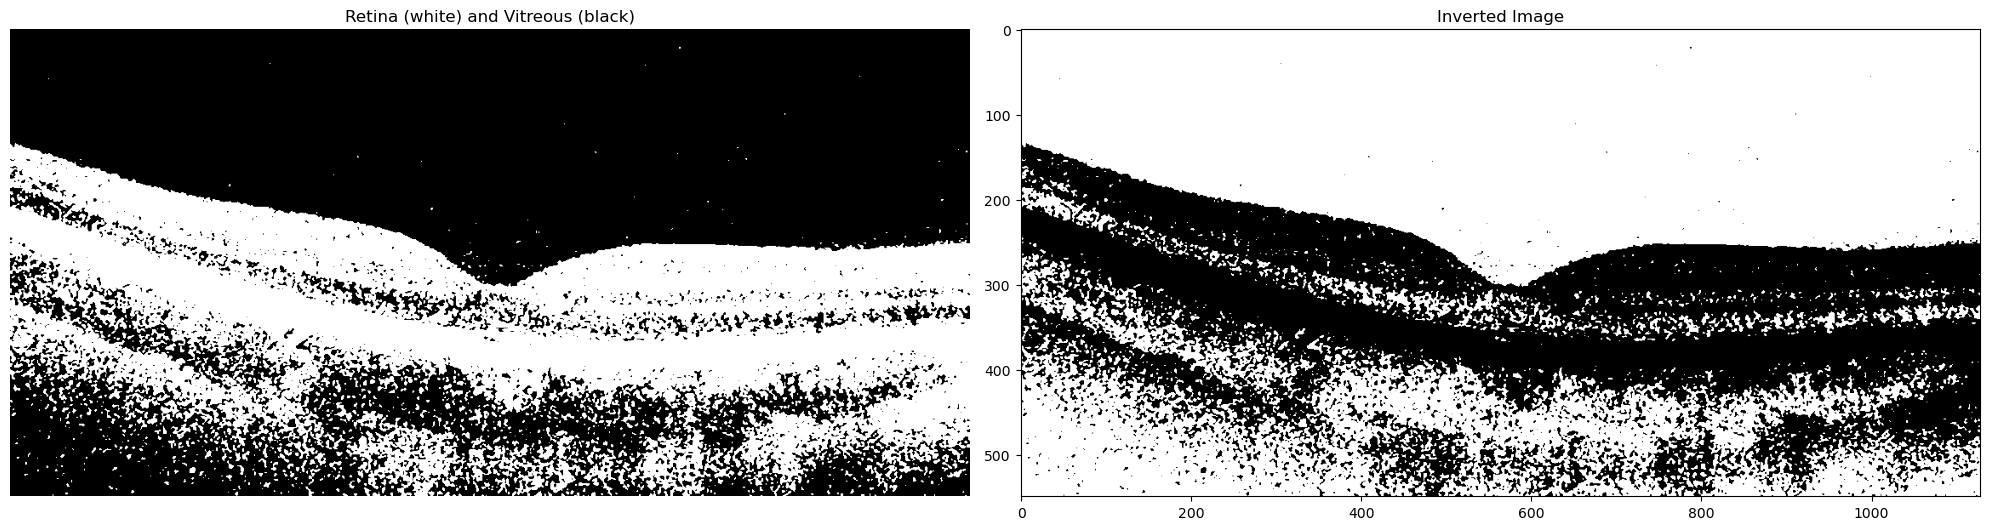

In [5]:
# Define a threshold value
threshold_value = .08

# Apply binary thresholding to segment the image
retina_mask = (normalized_image > threshold_value) 


# Display the segmented regions

plt.figure(figsize=(5, 5))  # Define the figure size

plt.figure(figsize=(20, 10))  # Define the figure size
plt.subplot(1, 2, 1)  # Subplot for the image
plt.imshow(retina_mask, cmap='Greys_r')
plt.axis('off')  # Turn off the axis labels
plt.title('Retina (white) and Vitreous (black)')

plt.subplot(1, 2, 2)  # Subplot for the histogram
plt.imshow(255-retina_mask, cmap='Greys_r')
plt.title('Inverted Image')

plt.tight_layout()
plt.show()



**Task 2: Edge detection**

**Sobel operation**

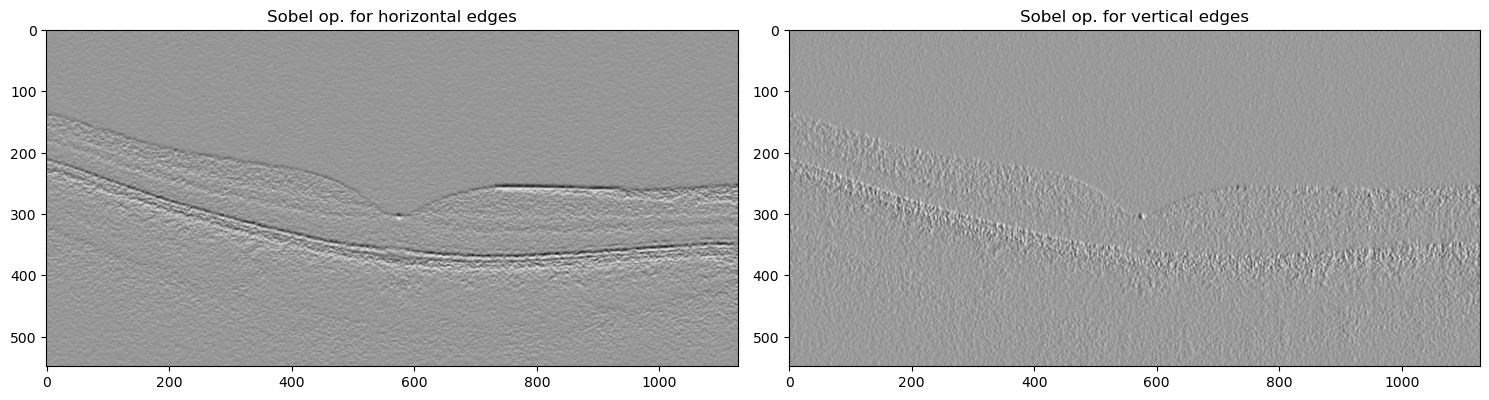

In [6]:
#Sobel operation
sobel_vertical = cv2.Sobel(normalized_image, cv2.CV_64F, 1,0, ksize = 3) #Kernel size equals 3, operation in x direction
sobel_horizontal = cv2.Sobel(normalized_image, cv2.CV_64F, 0,1, ksize = 3) #Kernel size equals 3, operation in y direction



plt.figure(figsize=(15, 10))  # Define the figure size
plt.subplot(1, 2, 1)  # Subplot for the image
plt.imshow(sobel_horizontal, cmap = 'Greys')
plt.title('Sobel op. for horizontal edges')

plt.subplot(1, 2, 2)  # Subplot for the histogram
plt.imshow(sobel_vertical , cmap = 'Greys')
plt.title('Sobel op. for vertical edges')

plt.tight_layout()
plt.show()

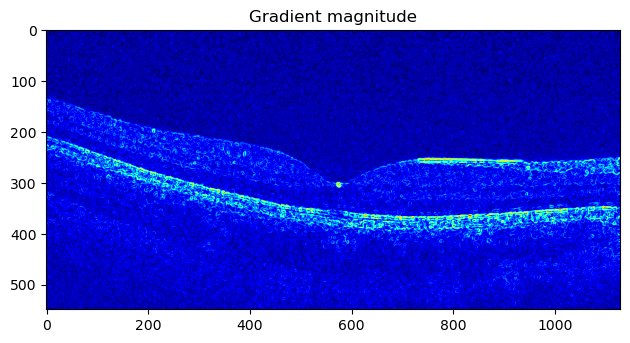

In [7]:
#equations from the lecture slides of image preprocessing
gradient_magnitude = np.sqrt((sobel_vertical ** 2) + (sobel_horizontal ** 2))
gradient_orientation = np.arctan2(sobel_horizontal,sobel_vertical) * (180 / np.pi) % 180

#plot images, the mapped colours are changed for a better visibilty
plt.imshow(gradient_magnitude, cmap = 'jet')
plt.title('Gradient magnitude')


plt.tight_layout()
plt.show()

**Gradient magnitude image**

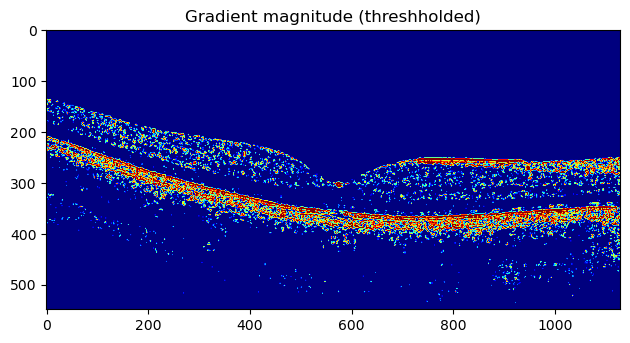

In [16]:
#Define a threshhold for the Gradient magnitude image
threshold_value_magnitude = 0.4

gradient_magnitude_thresh = (gradient_magnitude > threshold_value_magnitude)

plt.imshow(gradient_magnitude_thresh, cmap = 'jet')
plt.title('Gradient magnitude (threshholded)')
plt.tight_layout()
plt.show()

**Canny Edge implementation**

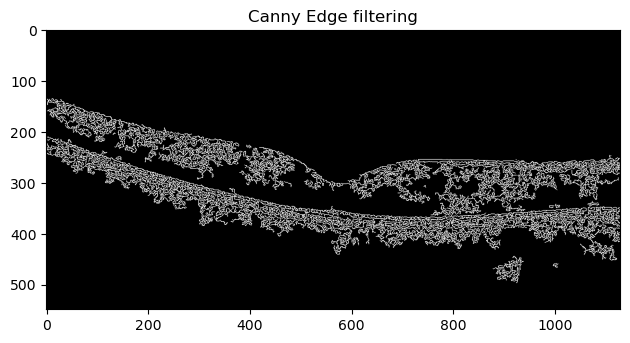

In [34]:
#transform the image to an 8-bit image
normalized_image_8bit = (normalized_image*255).astype(np.uint8)
image_canny = cv2.Canny(normalized_image_8bit, 50, 200)

plt.imshow(image_canny, cmap = 'Greys_r')
plt.title('Canny Edge filtering')

plt.tight_layout()
plt.show()


**Task 3: Image segmentation**

**Otsu thresholding**

50.0


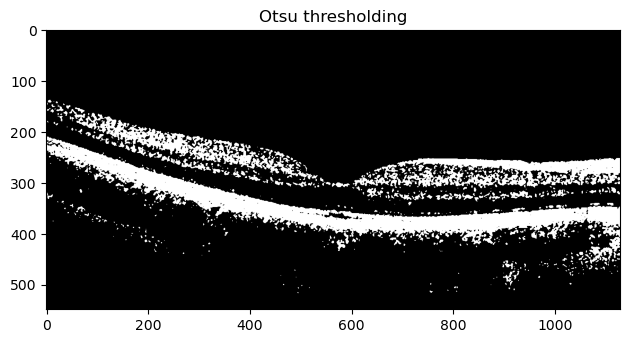

In [10]:
ret,thresh = cv2.threshold(normalized_image_8bit,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

print(ret)
plt.imshow(thresh, cmap = 'Greys_r')
plt.title('Otsu thresholding')

plt.tight_layout()
plt.show()

**Segmentation with K-means clustering**

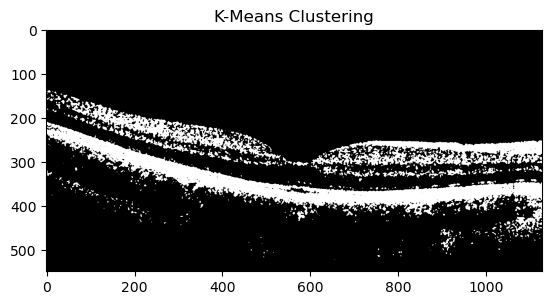

In [22]:
#Stopping criteria: Algorithm is stopped when the accuracy 0.2 is reached and the maximum of 100 iterations is reached
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.8) 

#K-Means algorithm needs the image data in one column so in the following the image is reshaped
#the normalized 8-bit image is used as input
reshaped_image = normalized_image_8bit.reshape((-1, 1))
#Data format has to be float32 for the algorithm
reshaped_image = np.float32(reshaped_image)

#Number of required cluster K= 2; One for the Retina, one for the vitreous and the choroid
k = 2
#K-Means clustering algorithm with defined 'k' and criteria and 50 attempts
compactness, labels, (centers) = cv2.kmeans(reshaped_image, k, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS)

#convert and reshape back to the original format
centers = np.uint8(centers)
labels = labels.flatten()
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(normalized_image_8bit.shape)

#plot everything 
plt.title('K-Means Clustering')
plt.imshow(segmented_image, cmap='Greys_r')
plt.show()